# Model Building

In [1]:
# Standard imports
import numpy as np
import pandas as pd
from pydantic import BaseModel, ValidationError
import yaml

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Built-in library
import itertools
import re
import json
import typing as tp

import warnings

warnings.filterwarnings("error")

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)


from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.discretisation import EqualFrequencyDiscretiser

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# Custom Imports
from data_manager import load_data, validate_input
import feat_engineering as fe
from schema import (
    TrainingSchema,
    ValidateTrainingData,
    ModelConfig,
    MLFlowConfig,
    ConfigVars,
)

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Data

In [2]:
# Load Data
train_data = load_data("data/yellow_tripdata_2022-01.parquet")
test_data = load_data("data/yellow_tripdata_2022-02.parquet")

print(f"Shape of: \ntrain_data: {train_data.shape}\ntest_data: {test_data.shape}\n")

train_data.head()

Shape of: 
train_data: (2406155, 20)
test_data: (2901257, 20)



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,2.934920
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,2.240710
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,2.299581
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,2.400619
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,3.651437


### Load Config

In [3]:
fp = "config.yml"

with open(fp, "r") as file:
    config_file = yaml.safe_load(stream=file)

config_file

{'RANDOM_STATE': 123,
 'TEST_SIZE': 0.1,
 'TARGET': 'trip_duration',
 'NUMERICAL_VARS': ['VendorID',
  'tpep_pickup_datetime',
  'tpep_dropoff_datetime',
  'passenger_count',
  'trip_distance',
  'RatecodeID',
  'PULocationID',
  'DOLocationID',
  'payment_type',
  'fare_amount',
  'extra',
  'mta_tax',
  'tip_amount',
  'tolls_amount',
  'improvement_surcharge',
  'total_amount',
  'congestion_surcharge',
  'airport_fee'],
 'CATEGORICAL_VARS': ['store_and_fwd_flag'],
 'NUM_VARS_WF_NA': ['RatecodeID'],
 'INPUT_FEATURES': ['DOLocationID',
  'payment_type',
  'PULocationID',
  'RatecodeID',
  'total_amount',
  'tpep_pickup_datetime',
  'trip_distance',
  'VendorID'],
 'IMPORTANT_FEATURES': ['day_of_week',
  'DOLocationID',
  'hour_of_day',
  'payment_type',
  'PULocationID',
  'RatecodeID',
  'RatecodeID_na',
  'total_amount',
  'tpep_pickup_datetime',
  'trip_distance',
  'VendorID'],
 'VARS_TO_DROP': ['tpep_pickup_datetime'],
 'VARS_TO_LOG_TRANSFORM': ['trip_distance', 'total_amount'],

In [4]:
config = ConfigVars(
    model_config=ModelConfig(**config_file), mlflow_config=MLFlowConfig(**config_file)
)

config.model_config.VARS_TO_LOG_TRANSFORM
config.model_config.TEMPORAL_VAR

'tpep_pickup_datetime'

In [5]:
# Split the data
X = train_data.drop(columns=[config.model_config.TARGET])
y = train_data[config.model_config.TARGET]

X_train, X_validate, y_train, y_validate = train_test_split(
    X,
    y,
    test_size=config.model_config.TEST_SIZE,
    random_state=config.model_config.RANDOM_STATE,
)

X_train.shape, X_validate.shape

((2165539, 19), (240616, 19))

### Pipeline

In [6]:
lr_pipe = Pipeline(
    steps=[
        # ===== Select input features =====
        (
            "input vars",
            fe.SelectFeatures(features=config.model_config.INPUT_FEATURES),
        ),
        # ===== Add NaN flags =====
        (
            "add na_flag",
            AddMissingIndicator(
                missing_only=True, variables=config.model_config.NUM_VARS_WF_NA
            ),
        ),
        # ===== Impute NaNs =====
        (
            "impute num_vars",
            MeanMedianImputer(
                imputation_method="median", variables=config.model_config.NUM_VARS_WF_NA
            ),
        ),
        # ===== Create new features =====
        (
            "cal day_of_week",
            fe.CalculateDayOfWeek(feature=config.model_config.TEMPORAL_VAR),
        ),
        (
            "cal hour_of_day",
            fe.CalculateHourOfDay(feature=config.model_config.TEMPORAL_VAR),
        ),
        # ===== Select features =====
        (
            "important vars",
            fe.SelectFeatures(features=config.model_config.IMPORTANT_FEATURES),
        ),
        # ===== Drop features =====
        (
            "drop features",
            DropFeatures(features_to_drop=config.model_config.VARS_TO_DROP),
        ),
        # ===== Transform features =====
        (
            "log transformation",
            LogTransformer(
                variables=config.model_config.VARS_TO_LOG_TRANSFORM, base="e"
            ),
        ),
        # ===== Scale features =====
        ("scale data", StandardScaler()),
        # ===== Linear model =====
        ("linear model", LinearRegression()),
    ]
)
lr_pipe

Pipeline(steps=[('input vars',
                 SelectFeatures(features=['DOLocationID', 'payment_type',
                                          'PULocationID', 'RatecodeID',
                                          'total_amount',
                                          'tpep_pickup_datetime',
                                          'trip_distance', 'VendorID'])),
                ('add na_flag', AddMissingIndicator(variables=['RatecodeID'])),
                ('impute num_vars',
                 MeanMedianImputer(variables=['RatecodeID'])),
                ('cal day_of_week',
                 CalculateDayOfWeek(feature='...
                                          'hour_of_day', 'payment_type',
                                          'PULocationID', 'RatecodeID',
                                          'RatecodeID_na', 'total_amount',
                                          'tpep_pickup_datetime',
                                          'trip_distance', 'VendorID'])),
                ('drop features',
                 DropFeatures(features_to_drop=['tpep_pickup_datetime'])),
                ('log transformation',
                 LogTransformer(variables=['trip_distance', 'total_amount'])),
                ('scale data', StandardScaler()),
                ('linear model', LinearRegression())])

In [7]:
lr_pipe.fit(X_train, y_train)
# Predictions using train data
y_pred_train = lr_pipe.predict(X_train)

# Predictions using validation data
y_pred = lr_pipe.predict(X_validate)

In [8]:
# Train data
# Note: The trip_duration is in "log base e"
mse = metrics.mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False)

# Convert to minutes: Find the exponential
np.exp(mse)

1.3359982911694641

In [9]:
# Validation Dataset
# Note: The trip_duration is in "log base e"
mse = metrics.mean_squared_error(y_true=y_validate, y_pred=y_pred, squared=False)

# Convert to minutes: Find the exponential
np.exp(mse)

1.335991742794761

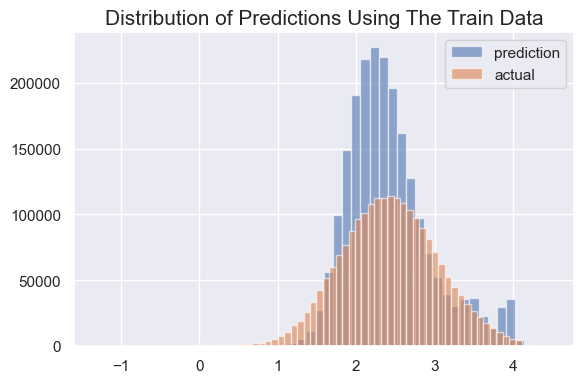

In [10]:
plt.figure(figsize=[6, 4])

plt.hist(y_pred_train, bins=50, alpha=0.6, label="prediction")
plt.hist(y_train, bins=50, alpha=0.6, label="actual")
plt.title("Distribution of Predictions Using The Train Data", size=15)

plt.legend(loc="best")
plt.tight_layout()
plt.show()

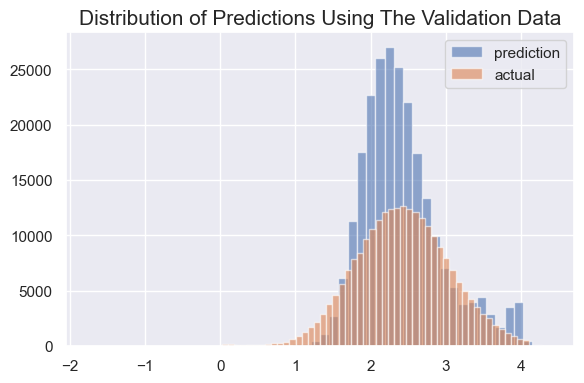

In [11]:
plt.figure(figsize=[6, 4])

plt.hist(y_pred, bins=50, alpha=0.6, label="prediction")
plt.hist(y_validate, bins=50, alpha=0.6, label="actual")
plt.title("Distribution of Predictions Using The Validation Data", size=15)

plt.legend(loc="best")
plt.tight_layout()
plt.show()

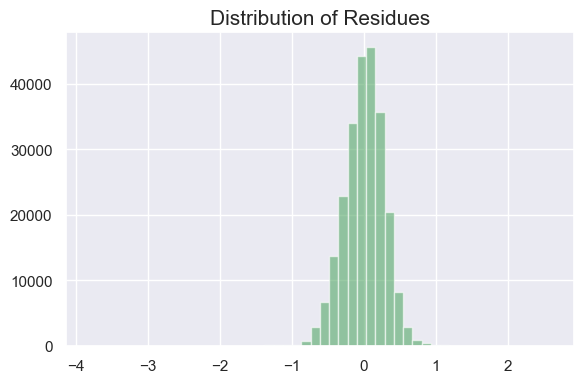

In [12]:
plt.figure(figsize=[6, 4])

plt.hist(y_validate - y_pred, bins=50, alpha=0.6, color="g")
plt.title("Distribution of Residues", size=15)

# plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [13]:
# Persist Data
fp = "models/linear_model_v001.joblib"

with open(fp, "wb") as file:
    joblib.dump(value=lr_pipe, filename=file)

## Preprocessing Pipeline

In [14]:
processor_pipe = Pipeline(
    steps=[
        # ===== Select input features =====
        (
            "input vars",
            fe.SelectFeatures(features=config.model_config.INPUT_FEATURES),
        ),
        # ===== Add NaN flags =====
        (
            "add na_flag",
            AddMissingIndicator(
                missing_only=True, variables=config.model_config.NUM_VARS_WF_NA
            ),
        ),
        # ===== Impute NaNs =====
        (
            "impute num_vars",
            MeanMedianImputer(
                imputation_method="median", variables=config.model_config.NUM_VARS_WF_NA
            ),
        ),
        # ===== Create new features =====
        (
            "cal day_of_week",
            fe.CalculateDayOfWeek(feature=config.model_config.TEMPORAL_VAR),
        ),
        (
            "cal hour_of_day",
            fe.CalculateHourOfDay(feature=config.model_config.TEMPORAL_VAR),
        ),
        # ===== Select features =====
        (
            "important vars",
            fe.SelectFeatures(features=config.model_config.IMPORTANT_FEATURES),
        ),
        # ===== Drop features =====
        (
            "drop features",
            DropFeatures(features_to_drop=config.model_config.VARS_TO_DROP),
        ),
        # ===== Transform features =====
        (
            "log transformation",
            LogTransformer(
                variables=config.model_config.VARS_TO_LOG_TRANSFORM, base="e"
            ),
        ),
        # ===== Scale features =====
        ("scale data", StandardScaler()),
    ]
)
processor_pipe

Pipeline(steps=[('input vars',
                 SelectFeatures(features=['DOLocationID', 'payment_type',
                                          'PULocationID', 'RatecodeID',
                                          'total_amount',
                                          'tpep_pickup_datetime',
                                          'trip_distance', 'VendorID'])),
                ('add na_flag', AddMissingIndicator(variables=['RatecodeID'])),
                ('impute num_vars',
                 MeanMedianImputer(variables=['RatecodeID'])),
                ('cal day_of_week',
                 CalculateDayOfWeek(feature='...
                 SelectFeatures(features=['day_of_week', 'DOLocationID',
                                          'hour_of_day', 'payment_type',
                                          'PULocationID', 'RatecodeID',
                                          'RatecodeID_na', 'total_amount',
                                          'tpep_pickup_datetime',
                                          'trip_distance', 'VendorID'])),
                ('drop features',
                 DropFeatures(features_to_drop=['tpep_pickup_datetime'])),
                ('log transformation',
                 LogTransformer(variables=['trip_distance', 'total_amount'])),
                ('scale data', StandardScaler())])

In [15]:
### Transform data
processed_data = processor_pipe.fit_transform(X_train)

# NumPy Array
processed_data

array([[-1.00089976, -0.30748805, -1.00089976, ...,  0.15052504,
         0.40631037, -1.46047044],
       [-0.50248195, -1.35582406, -0.50248195, ...,  0.13325217,
         0.23608744, -1.46047044],
       [-0.50248195,  1.024182  , -0.50248195, ..., -0.16442454,
        -0.1382306 ,  0.61546867],
       ...,
       [ 0.99277148,  1.06668211,  0.99277148, ...,  0.59358628,
         0.82744054, -1.46047044],
       [-0.50248195,  0.00417941, -0.50248195, ..., -0.6083715 ,
        -0.21165277, -1.46047044],
       [-0.50248195,  1.03834871, -0.50248195, ...,  0.03242537,
         0.09910066,  0.61546867]])

In [16]:
# Persist Data
fp = "models/processor_pipeline.joblib"

with open(fp, "wb") as file:
    joblib.dump(value=processor_pipe, filename=file)

## Make Predictions Using Unseen Data

In [17]:
new_data = {
    "DOLocationID": [82, 72],
    "payment_type": [1, 2],
    "PULocationID": [5, 99],
    "RatecodeID": [np.nan, 2],
    "tpep_pickup_datetime": ["2022-12-16 14:33:43", "2022-12-18 09:18:03"],
    "trip_distance": [5.5, 3.1],
    "VendorID": [2, 1],
    "total_amount": [12, 9.5],
}

new_data

{'DOLocationID': [82, 72],
 'payment_type': [1, 2],
 'PULocationID': [5, 99],
 'RatecodeID': [nan, 2],
 'tpep_pickup_datetime': ['2022-12-16 14:33:43', '2022-12-18 09:18:03'],
 'trip_distance': [5.5, 3.1],
 'VendorID': [2, 1],
 'total_amount': [12, 9.5]}

In [18]:
def make_predictions(*, data: tp.Dict) -> pd.DataFrame:
    """This returns the predictions."""
    if len(data.get("DOLocationID")) == 1:
        df = pd.DataFrame(new_data, index=[0])
    else:
        df = pd.DataFrame(new_data)
    # Conevrt to datetime
    df["tpep_pickup_datetime"] = pd.to_datetime(
        df["tpep_pickup_datetime"], errors="coerce"
    )
    # Validate the input
    df, error = validate_input(data=df)
    if error is None:
        # Make predictions
        pred = lr_pipe.predict(df)
        pred = list(np.exp(pred))  # Convert from log to minutes
        df["trip_duration_mins"] = [round(x) for x in pred]
        return df
    else:
        raise Exception("Input data cannot be validated!")

In [19]:
make_predictions(data=new_data)

,DOLocationID,payment_type,PULocationID,RatecodeID,tpep_pickup_datetime,trip_distance,VendorID,total_amount,trip_duration_mins
0,82,1,5,NaN,2022-12-16 14:33:43,5.5,2,12.0,14
1,72,2,99,2.0,2022-12-18 09:18:03,3.1,1,9.5,11
